In [1]:
import os
from ultralytics import YOLO
import math
import csv
import cv2
import numpy as np
import pandas as pd

In [2]:
model_path = "plantation_model.pt"

image_dir = "Area_plantation/0/chunks"
#image_dir = os.path.join(pwd, image_dir)

annotated_images_dir = "test_plantations"
# Create annotated images directory if it doesn't exist
os.makedirs(annotated_images_dir, exist_ok=True)

csv_file = "Raman.csv"

zoom  = 17

In [3]:
# Define class-specific confidence thresholds
conf_thresholds = {
    #'plantations': 0.61,
    'plantations': 0.3,

}

# Class names (ensure these match the order used in your model training)
class_names = [
    'plantations',

]

# Mapping of class names to abbreviations
class_abbreviations = {
    'plantations': 'P',

}

In [ ]:
model = YOLO(model_path)

In [5]:
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

In [49]:
def process_image(image_path, conf_thresholds):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return None, None, None, None, None

    results = model.predict(img)

    polygons = []
    pred_classes = []
    conf_scores = []
    masks = []

    if results[0].masks is not None:
        for i, (polygon, mask, cls, conf) in enumerate(zip(results[0].masks.xy, results[0].masks.data.cpu().numpy(), results[0].boxes.cls.cpu().numpy(), results[0].boxes.conf.cpu().numpy())):
            class_name = class_names[int(cls)]
            if conf >= conf_thresholds[class_name]:
                polygons.append(polygon)
                pred_classes.append(class_name)
                conf_scores.append(conf)
                masks.append(mask)
    sum_array = np.sum(masks, axis=0)
    binary_array = (sum_array > 0).astype(np.uint8)
    return image_path, len(polygons), polygons, binary_array, pred_classes, conf_scores, results

In [69]:
_, _, _, mask, _, _, results = process_image("Area_plantation/0/chunks/chunk_15_14.tif", conf_thresholds)

0: 256x256 2 Plantationss, 64.4ms
Speed: 2.4ms preprocess, 64.4ms inference, 6.0ms postprocess per image at shape (1, 3, 256, 256)


In [70]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1]], dtype=uint8)

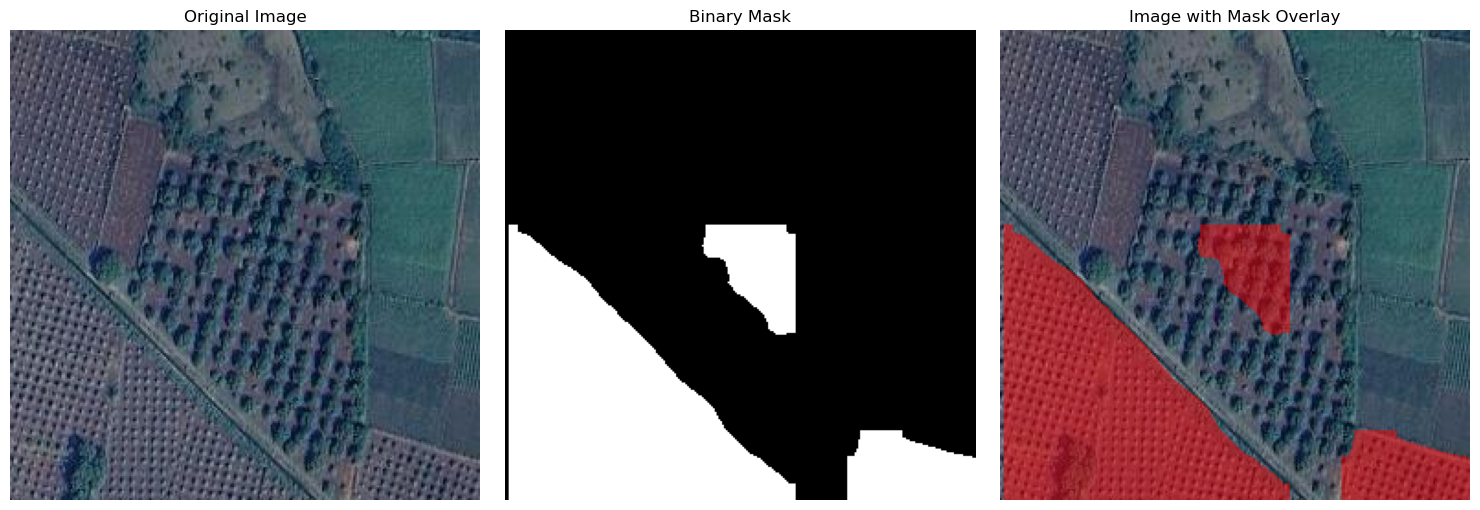

In [71]:
import matplotlib.pyplot as plt

# ---- Step 1: Read the image using OpenCV ----
image_path = "Area_plantation/0/chunks/chunk_15_14.tif"  # Replace with your image path
image = cv2.imread(image_path)  # Loads in BGR format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display


# ---- Step 3: Create overlay using mask ----
overlay = image_rgb.copy()
overlay[mask == 1] = [255, 0, 0]  # Red color overlay

# ---- Step 4: Blend original image and overlay ----
alpha = 0.5
blended = image_rgb.copy()
blended[mask == 1] = (alpha * overlay[mask == 1] + (1 - alpha) * image_rgb[mask == 1]).astype(np.uint8)

# ---- Step 5: Display using matplotlib ----
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Binary Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Image with Mask Overlay')
plt.imshow(blended)
plt.axis('off')

plt.tight_layout()
plt.show()
